Author Type Labeling
===

Labeling of authors and sites based on update-level author type predictions.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
import sys
sys.path.append("/home/srivbane/levon003/repos/qual-health-journeys/annotation_data")
import journal as journal_utils

In [4]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"

In [5]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [6]:
p_thresh = 0.66
cg_thresh = 0.34

## Read in the data

And convert it to a new dataframe that aggregates at the user/site level.

In [7]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:19.435588


15850052

In [8]:
journal_df = journal_df[journal_df.is_nontrivial]

In [9]:
journal_df.head(n=3)

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial,predicted_label
0,1103856900000,51bdf3e56ca0048f4e00ced4,0,1,1103856900000,1,0,True,cg
1,1103943240000,51bdf3e56ca0048f4e00ced2,0,1,1103943240000,1,1,True,cg
2,1104288840000,51bdf3e56ca0048f4e00ced0,0,1,1104288840000,1,2,True,cg


In [10]:
Counter(journal_df.predicted_label).most_common()

[('cg', 11707863), ('p', 3890387)]

In [11]:
# what's the overall percentage that are patient-authored
np.sum(journal_df.predicted_label == 'p') / len(journal_df)

0.24941176093472023

In [37]:
# generate a series with a multilevel index of user_id/site_id
user_proportions = journal_df.groupby(['user_id', 'site_id']).agg({
    'predicted_label': lambda group: np.sum(group == 'p') / len(group),
    'site_index': lambda group: len(group)
})
# rename the resulting series
user_proportions = user_proportions.rename(columns={
    'predicted_label': 'patient_proportion', 
    'site_index': 'site_total'
})
user_proportions.tail()

,,patient_proportion,site_total
user_id,site_id,,
40905335,1327430,0.0,4
40906769,1327430,0.0,1
40914864,1328992,0.0,5
40933432,1330148,1.0,4
40972477,1333192,1.0,1


In [38]:
user_site_df = user_proportions.reset_index(level=user_proportions.index.names)
user_site_df.head()

,user_id,site_id,patient_proportion,site_total
0,0,44,0.000000,72
1,0,102,0.369565,46
2,0,308,0.166667,12
3,0,664,0.000000,5
4,0,670,0.028571,315


In [12]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [13]:
# load the list of valid sites
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

340414

In [39]:
# this doesn't actually trim any data out
user_site_df = user_site_df[(user_site_df.user_id.isin(valid_user_ids))|(user_site_df.site_id.isin(valid_site_ids))]
len(user_site_df)

414566

In [40]:
user_site_df = user_site_df.reset_index(drop=True)
user_site_df.head()

,user_id,site_id,patient_proportion,site_total
0,0,44,0.000000,72
1,0,102,0.369565,46
2,0,308,0.166667,12
3,0,664,0.000000,5
4,0,670,0.028571,315


In [ ]:
# save the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_site_patient_proportions_filepath = os.path.join(author_type_dir, 'user_site_patient_proportions.df')
user_site_df.to_feather(user_site_patient_proportions_filepath)
print("Finished.")

In [41]:
# load the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_site_patient_proportions_filepath = os.path.join(author_type_dir, 'user_site_patient_proportions.df')
user_site_df = pd.read_feather(user_site_patient_proportions_filepath)
len(user_site_df)

414566

#### Define some dates for further visualization

In [42]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
subset_start_date = datetime.fromisoformat('2014-01-01')
subset_start_timestamp = int(subset_start_date.timestamp() * 1000)
bins = []
bins.append(start_date.timestamp() * 1000)
year = 2005
month = 1
while year != 2016 or month != 6:
    if month == 12:
        year += 1
        month = 1
    else:
        month += 1
    bins.append(datetime.fromisoformat(f"{year}-{month:02}-01").timestamp() * 1000)
len(bins)

138

## Site-level labeling

In [43]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
# note that only 41 updates have this issue
invalid_created_at = journal_df.created_at <= 0
journal_df.loc[invalid_created_at, 'created_at'] = journal_df.loc[invalid_created_at, 'updated_at']
journal_df[invalid_created_at]

,created_at,journal_oid,published_at,site_id,updated_at,user_id,site_index,is_nontrivial,predicted_label
6108595,1350431833000,51be21ae6ca004d95f00f934,0,155746,1350431833000,7262862,0,True,p
6294742,1324264882000,51be23926ca004d26501107b,0,163675,1324264882000,7650926,0,True,p
6691857,1333021807000,51c060d76ca00467161b4df8,0,177974,1333021807000,8445081,0,True,p
6992753,1333203198000,51be29b86ca004987900c68b,0,190049,1333203198000,9031661,0,True,cg
7600252,1342800930000,51be2eba6ca004210b00cc45,0,210183,1342800930000,10139305,0,True,cg
7826961,1325601853000,51be309e6ca0047c11005896,0,223715,1325601853000,3638273,0,True,cg
8756897,1333506884000,51be3f316ca0044b40003d1a,0,311670,1333506884000,14356764,0,True,cg
8880348,1327535045000,51be411d6ca004cb46008cb7,0,332166,1327535045000,14793568,0,True,cg
9501496,1317350093000,51be491d6ca004e761002ecb,0,404252,1317350093000,16797514,0,True,cg
9611424,1321721744000,51be4a7b6ca0047c66002933,0,416488,1321721744000,17168846,0,True,p


In [44]:
# generate a dataframe with an index of site_id
site_proportions = journal_df.groupby(['site_id']).agg({
    'predicted_label': lambda group: np.sum(group == 'p') / len(group),
    'site_index': lambda group: len(group),
    'user_id': lambda group: len(set(group)),
    'created_at': lambda group: np.min(group)
})
# rename the resulting columns
site_proportions = site_proportions.rename(columns={
    'predicted_label': 'patient_proportion', 
    'site_index': 'site_total',
    'user_id': 'num_authors',
    'created_at': 'first_update_created_at'
})
site_proportions.tail()

,patient_proportion,site_total,num_authors,first_update_created_at
site_id,,,,
1334300,0.0,1,1,1549749147000
1334403,0.0,2,1,1549765406000
1334702,0.0,2,1,1549817607000
1334735,1.0,1,1,1549823254000
1334755,0.0,1,1,1549824852000


In [45]:
site_df = site_proportions.reset_index(level=site_proportions.index.names)
original_size = len(site_df)
site_df = site_df[site_df.site_id.isin(valid_site_ids)]
len(site_df), len(site_df) / original_size

(340414, 1.0)

In [46]:
site_df.head()

,site_id,patient_proportion,site_total,num_authors,first_update_created_at
0,1,0.032086,187,1,1103856900000
1,2,0.068966,29,1,1117053060000
2,6,0.000000,17,1,1112730300000
3,10,0.000000,15,1,1116042900000
4,13,0.250000,12,1,1117550400000


In [47]:
# percent of multiauthor sites
np.sum(site_df.num_authors > 1) / len(site_df)

0.1603253685218587

In [48]:
site_types = []

site_subset = site_df
for patient_proportion, site_total, num_authors in zip(site_subset.patient_proportion, site_subset.site_total, site_subset.num_authors):
    if patient_proportion >= p_thresh:
        site_type = 'p'
    elif patient_proportion > cg_thresh:
        site_type = 'mixed'
    else:
        site_type = 'cg'
    site_types.append(site_type)

In [49]:
site_types_single_author = []
site_types_multi_author = []

site_subset = site_df[site_df.num_authors == 1]
for patient_proportion, site_total, num_authors in zip(site_subset.patient_proportion, site_subset.site_total, site_subset.num_authors):
    if patient_proportion >= p_thresh:
        site_type = 'p'
    elif patient_proportion > cg_thresh:
        site_type = 'mixed'
    else:
        site_type = 'cg'
    site_types_single_author.append(site_type)
    
site_subset = site_df[site_df.num_authors > 1]
for patient_proportion, site_total, num_authors in zip(site_subset.patient_proportion, site_subset.site_total, site_subset.num_authors):
    if patient_proportion >= p_thresh:
        site_type = 'p'
    elif patient_proportion > cg_thresh:
        site_type = 'mixed'
    else:
        site_type = 'cg'
    site_types_multi_author.append(site_type)

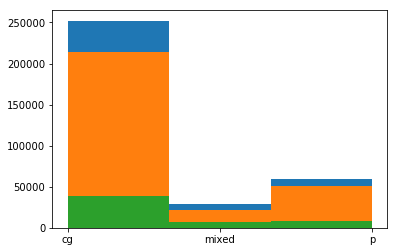

In [50]:
total_counts, bin_edges, _ = plt.hist(site_types, bins=3)
single_author_counts, bin_edges, _ = plt.hist(site_types_single_author, bins=bin_edges)
multi_author_counts, bin_edges, _ = plt.hist(site_types_multi_author, bins=bin_edges)

plt.show()

In [51]:
# multi-author sites are much more likely to be mixed
single_author_counts / len(site_types_single_author), multi_author_counts / len(site_types_multi_author)

(array([0.74820265, 0.07517571, 0.17662164]),
 array([0.70047822, 0.13679755, 0.16272422]))

In [74]:
site_df['site_author_type'] = site_types

In [75]:
# sites with more updates are more likely to be of mixed author type
print("    P   Mixed     CG")
for min_journal_count in [0, 2, 5, 10, 20, 50]:
    author_types = site_df[site_df.site_total >= min_journal_count].site_author_type
    c = Counter(author_types)
    t = len(author_types)
    print(f"{min_journal_count} {len(author_types)}\n{c['p']/t*100:>5.2f}% {c['mixed']/t*100:>5.2f}% {c['cg']/t*100:>5.2f}%")

    P   Mixed     CG
0 340414
17.44%  8.51% 74.06%
2 333324
17.42%  8.69% 73.89%
5 299124
17.13%  8.87% 74.01%
10 252099
17.52%  9.34% 73.14%
20 179111
18.37% 10.01% 71.62%
50 80117
18.79% 10.63% 70.57%


In [76]:
# there doesn't seem to be a strong interaction between length of site and multi-authorship
print("           P   Mixed     CG")
for min_journal_count in [0, 2, 5, 10, 20, 50]:
    print(f"{min_journal_count}")
    author_types = site_df[(site_df.site_total >= min_journal_count)&(site_df.num_authors == 1)].site_author_type
    c = Counter(author_types)
    t = len(author_types)
    print(f"Single:{c['p']/t*100:>5.2f}% {c['mixed']/t*100:>5.2f}% {c['cg']/t*100:>5.2f}%")
          
    author_types = site_df[(site_df.site_total >= min_journal_count)&(site_df.num_authors > 1)].site_author_type
    c = Counter(author_types)
    t = len(author_types)
    print(f" Multi:{c['p']/t*100:>5.2f}% {c['mixed']/t*100:>5.2f}% {c['cg']/t*100:>5.2f}%")

           P   Mixed     CG
0
Single:17.66%  7.52% 74.82%
 Multi:16.27% 13.68% 70.05%
2
Single:17.65%  7.71% 74.64%
 Multi:16.27% 13.68% 70.05%
5
Single:17.29%  7.79% 74.92%
 Multi:16.39% 13.81% 69.80%
10
Single:17.65%  8.18% 74.17%
 Multi:16.98% 14.12% 68.90%
20
Single:18.34%  8.83% 72.83%
 Multi:18.49% 14.31% 67.20%
50
Single:18.23%  9.53% 72.24%
 Multi:20.45% 13.87% 65.68%


In [ ]:
# randomly sample some of the mixed sites
site_subset = site_df[(site_df.site_total >= 20)&(site_df.site_author_type == 'mixed')&(site_df.first_update_created_at >= subset_start_timestamp)&(site_df.first_update_created_at <= end_timestamp)]
print(len(site_subset), len(site_df))
site_sample = site_subset.sample(n=10).copy()
site_sample['link'] = site_sample.site_id.apply(lambda site_id: f"https://127.0.0.1:5000/siteId/{site_id}")
site_sample[['site_id', 'site_total', 'patient_proportion', 'num_authors', 'link']]
# Annotations of the sample:
# 998001 caregiver-authored
# 1120684 patient-authored
# 1091588 mixed-authorship
# 927859 mostly patient-authored, with long initial post from family caregiver
# 1095759 mostly patient-authored, but then taken over by a caregiver who talks about her own stress in the wake of the death
# 895557 mixed-authorship, variety of authors
# 908309 patient authored but for the first update
# 1090868 mixed-authorship, with daughter taking over during worst of treatment/hopitalization
# 1033737 patient-authored, with a single guest-post from a caregiver
# 1003822 caregiver-authored

In [ ]:
# randomly sample some of the mixed sites
site_subset = site_df[(site_df.site_total >= 10)&(site_df.site_total <= 20)&(site_df.site_author_type == 'mixed')&(site_df.first_update_created_at >= subset_start_timestamp)&(site_df.first_update_created_at <= end_timestamp)]
print(len(site_subset), len(site_df))
site_sample = site_subset.sample(n=5).copy()
site_sample['link'] = site_sample.site_id.apply(lambda site_id: f"http://127.0.0.1:5000/siteId/{site_id}")
site_sample[['site_id', 'site_total', 'patient_proportion', 'num_authors', 'link']]
# 1099327 is mostly patient-authored, but most of its posts are after June 2016
# 909499 is mostly patient-authored, but the patient-authored posts have long block quotes from other texts

In [77]:
f"{np.sum(journal_df.created_at >= end_timestamp) / len(journal_df) * 100:.2f}% of updates occur after the end of the study period."

'3.85% of updates occur after the end of the study period.'

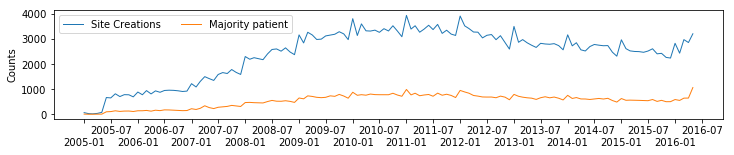

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))

site_labels = site_df.patient_proportion >= 0.5

hist, bin_edges = np.histogram(site_df.first_update_created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Site Creations')

hist, bin_edges = np.histogram(site_df[site_df.patient_proportion >= 0.5].first_update_created_at, bins=bins)
plt.plot(bin_edges[:-1], hist, linestyle='-', linewidth=1, label='Majority patient')

plt.legend(ncol=2)
plt.ylabel("Counts")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])
plt.show()

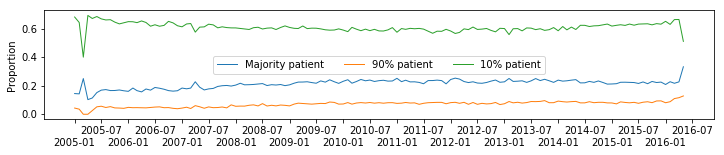

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))

site_labels = site_df.patient_proportion >= 0.5

all_counts, bin_edges = np.histogram(site_df.first_update_created_at, bins=bins)
subset_counts, bin_edges = np.histogram(site_df[site_df.patient_proportion >= 0.5].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='Majority patient')

subset_counts, bin_edges = np.histogram(site_df[site_df.patient_proportion >= 0.9].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='90% patient')

subset_counts, bin_edges = np.histogram(site_df[site_df.patient_proportion <= 0.1].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='10% patient')

plt.legend(ncol=3)
plt.ylabel("Proportion")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])
plt.show()

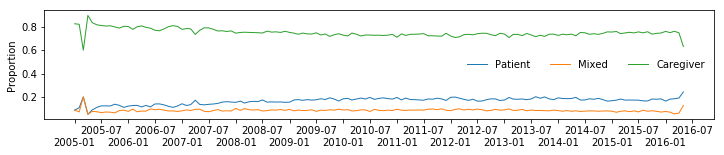

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12,2))

all_counts, bin_edges = np.histogram(site_df.first_update_created_at, bins=bins)
subset_counts, bin_edges = np.histogram(site_df[site_df.site_author_type == 'p'].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='Patient')

subset_counts, bin_edges = np.histogram(site_df[site_df.site_author_type == 'mixed'].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='Mixed')

subset_counts, bin_edges = np.histogram(site_df[site_df.site_author_type == 'cg'].first_update_created_at, bins=bins)
proportions = subset_counts / all_counts
plt.plot(bin_edges[:-1], proportions, linestyle='-', linewidth=1, label='Caregiver')

plt.legend(ncol=3, frameon=False)
plt.ylabel("Proportion")

newline = '\n'
xticks = [datetime.fromisoformat(f"{2005 + i // 2}-{'01' if i % 2 == 0 else '07'}-01").timestamp() * 1000 for i in range((2016 - 2005) * 2 + 2)]
plt.xticks(
    xticks, 
    [f"{newline if i%2 == 0 else ''}{datetime.utcfromtimestamp(be / 1000).strftime('%Y-%m')}" for i, be in enumerate(xticks)])
plt.show()

In [81]:
# these are the percentages for sites created in the 2014-2016 range 
site_subset = site_df[(site_df.first_update_created_at >= subset_start_timestamp)&(site_df.first_update_created_at <= end_timestamp)]
for label, count in Counter(site_subset.site_author_type).most_common():
    print(f"{label:>5} {count:>5}  {count / len(site_subset) * 100:>5.2f}%")

   cg 57042  74.09%
    p 13937  18.10%
mixed  6006   7.80%


In [82]:
# these are the percentages for sites created in the full range 
site_subset = site_df[(site_df.first_update_created_at >= start_timestamp)&(site_df.first_update_created_at <= end_timestamp)]
for label, count in Counter(site_subset.site_author_type).most_common():
    print(f"{label:>5} {count:>5}  {count / len(site_subset) * 100:>5.2f}%")

   cg 245961  74.09%
    p 57843  17.42%
mixed 28157   8.48%


In [ ]:
# save the site author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
site_patient_proportions_filepath = os.path.join(author_type_dir, 'site_patient_proportions.df')
site_df.to_feather(site_patient_proportions_filepath)
print("Finished.")

In [16]:
# read the site author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
site_patient_proportions_filepath = os.path.join(author_type_dir, 'site_patient_proportions.df')
site_author_type_df = pd.read_feather(site_patient_proportions_filepath)
len(site_author_type_df)

340414

In [17]:
site_df = site_author_type_df

## User labeling

In [52]:
user_site_df.head()

,user_id,site_id,patient_proportion,site_total
0,0,44,0.000000,72
1,0,102,0.369565,46
2,0,308,0.166667,12
3,0,664,0.000000,5
4,0,670,0.028571,315


In [15]:
is_shared_series = user_site_df[(user_site_df.site_total >= 10)&(user_site_df.user_id.isin(valid_user_ids))].groupby('user_id').agg({
    'patient_proportion': lambda prop: np.any((prop < p_thresh)&(prop > cg_thresh))
})['patient_proportion']

In [16]:
# the percentage of users with at least one site that has both 10+ updates and is shared 
np.sum(is_shared_series) / len(is_shared_series)

0.07906396354417583

In [18]:
# This is an upper bound on account sharing, although it likely captures mostly classifier noise
ub_is_shared_series = user_site_df[user_site_df.user_id.isin(valid_user_ids)].groupby('user_id').agg({
    'patient_proportion': lambda prop: np.any((prop < 1.0)&(prop > 0.0))
})['patient_proportion']
# the percentage of users with at least one site that is "shared"
np.sum(ub_is_shared_series) / len(ub_is_shared_series)

0.5342367081096745

In [53]:
# This is the actual Shared measure that's used
# Note: This takes quite a long time to run
is_shared_series = user_site_df[user_site_df.user_id.isin(valid_user_ids)].groupby('user_id').agg({
    'patient_proportion': lambda prop: np.any((prop < p_thresh)&(prop > cg_thresh))
})['patient_proportion']
# the percentage of users with at least one site that is shared 
np.sum(is_shared_series) / len(is_shared_series)

0.07464157087858257

In [54]:
# dictionary mapping user_id -> is 1+ of user's sites "shared"
is_user_shared_dict = is_shared_series.to_dict()

In [24]:
# TODO investigate shared sites
user_site_df.sample(n=10)

,user_id,site_id,patient_proportion,site_total
167678,7915192,167871,0.125000,16
160340,7402987,158104,0.048780,41
411169,33336667,1137399,0.000000,37
168524,7973579,168921,0.066667,15
236596,15084802,343792,0.916667,12
182512,8935893,256334,0.000000,6
370075,29899452,936783,0.473684,19
295359,22435533,880259,0.000000,15
354147,28670467,884055,0.230769,13
269176,19045006,895346,0.083333,24


In [55]:
result = user_site_df[user_site_df.user_id.isin(valid_user_ids)].groupby('user_id').agg(
    {
        'site_id': lambda group: len(group),
        'site_total': lambda group: list(group),
        'patient_proportion': lambda group: list(group)
    })
multisite_authors = result[result.site_id > 1]

In [56]:
user_stats = []
for user_id, site_totals, patient_proportions in tqdm(zip(multisite_authors.index, multisite_authors.site_total, multisite_authors.patient_proportion), total=len(multisite_authors)):
    total_sites = len(site_totals)
    u_df = pd.DataFrame({'site_total': site_totals, 'patient_proportion': patient_proportions})
    u_df = u_df[u_df.site_total >= 3]
    has_p_site = np.any(u_df.patient_proportion >= p_thresh)
    has_cg_site = np.any(u_df.patient_proportion <= cg_thresh)
    has_mixed_site = np.any((u_df.patient_proportion > cg_thresh)&(u_df.patient_proportion < p_thresh))
    d = {
        'user_id': user_id,
        'has_p_site': has_p_site,
        'has_cg_site': has_cg_site,
        'has_mixed_site': has_mixed_site,
    }
    user_stats.append(d)
    

100%|██████████| 18691/18691 [01:00<00:00, 308.22it/s]


In [57]:
multisite_df = pd.DataFrame(user_stats)
len(multisite_df)

18691

In [58]:
multisite_df.sample(n=10)

,user_id,has_p_site,has_cg_site,has_mixed_site
9740,9458853,False,True,False
14866,25508457,False,True,False
4693,3505700,False,True,False
11175,13308626,False,True,False
10378,10744303,True,True,False
12109,16200805,False,True,False
18466,32928193,False,False,False
7363,6220885,False,True,True
10662,11605918,False,True,False
7860,6783758,False,True,False


In [59]:
np.sum((multisite_df.has_p_site)&(multisite_df.has_cg_site)&(~has_mixed_site)) / len(multisite_df)

0.1110694986892087

In [60]:
subset = multisite_df[(multisite_df.has_p_site == True)&(multisite_df.has_cg_site == True)]
assert len(subset) == np.sum(subset.has_p_site)
assert len(subset) == np.sum(subset.has_cg_site)
non_shared_mixed_authors = subset[~subset.has_mixed_site]
len(non_shared_mixed_authors), len(non_shared_mixed_authors) / len(multisite_df)

(2028, 0.10850141779466053)

In [61]:
non_shared_mixed_authors_df = user_df[user_df.user_id.isin(non_shared_mixed_authors.user_id)]
len(non_shared_mixed_authors_df), np.sum(non_shared_mixed_authors_df.is_shared)

(2028, 0)

In [62]:
non_shared_mixed_authors_df

,user_id,patient_proportion,user_total,num_sites,user_author_type,is_shared
38,107,0.500000,10,3,mixed,False
261,2331,0.701923,104,2,p,False
272,2495,0.272727,33,2,cg,False
403,4756,0.620690,174,2,mixed,False
704,12279,0.772727,88,2,p,False
...,...,...,...,...,...,...
356793,32941010,0.189189,37,2,cg,False
357044,32967465,0.285714,7,2,cg,False
357417,33012699,0.684211,57,2,p,False
359044,33220545,0.392857,28,3,mixed,False


In [63]:
np.sum(user_df.is_shared) / len(user_df), np.sum(user_df.user_author_type == 'mixed') / len(user_df)

(0.07464157087858257, 0.07490927155059404)

In [64]:
np.sum((user_df.is_shared)&(user_df.user_author_type == 'mixed')) / np.sum(user_df.is_shared)

0.9624713451157287

In [65]:
np.sum((user_df.is_shared)&(user_df.user_author_type == 'mixed')) / np.sum(user_df.user_author_type == 'mixed')

0.9590317945695023

In [66]:
import scipy.stats
x1 = user_df.user_author_type == 'mixed'
x2 = user_df.is_shared
scipy.stats.pearsonr(x1, x2)

(0.9575780397377737, 0.0)

In [67]:
len(user_df)

362345

#### Now build the actual user author type dataframe

In [68]:
user_proportions = journal_df.groupby('user_id').agg({
    'predicted_label': lambda group: np.sum(group == 'p') / len(group),
    'site_index': lambda group: len(group),
    'site_id': lambda group: len(set(group))
})
# rename the resulting columns
user_proportions = user_proportions.rename(columns={
    'predicted_label': 'patient_proportion', 
    'site_index': 'user_total',
    'site_id': 'num_sites'
})

In [69]:
user_df = user_proportions.reset_index(level=user_proportions.index.names)
original_size = len(user_df)
user_df = user_df[user_df.user_id.isin(valid_user_ids)]
len(user_df), len(user_df) / original_size

(362345, 0.9492876641987729)

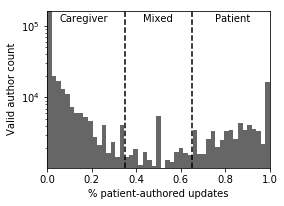

In [113]:
# TODO Show the distribution along with the thresholds
fig, ax = plt.subplots(1, 1, figsize=(5.47807 * 0.7, 2.8))
bins = np.linspace(0, 1, num=50)
#ax.hist(user_df.patient_proportion, bins=bins, alpha=0.1, log=True, color='black')
counts, edges, _ = ax.hist(user_df[user_df.user_total >= 1].patient_proportion, bins=bins, log=True, color='black', alpha=0.6)
plt.axvline(0.35, color='black', linestyle="--")
plt.axvline(0.65, color='black', linestyle="--")
plt.text(0.5, np.max(counts) * 0.9, 'Mixed', verticalalignment='top', horizontalalignment='center')
plt.text(1 / 3 / 2, np.max(counts) * 0.9, 'Caregiver', verticalalignment='top', horizontalalignment='center')
plt.text(2 / 3 + (1 / 3 / 2), np.max(counts) * 0.9, 'Patient', verticalalignment='top', horizontalalignment='center')
ax.set_xlabel("% patient-authored updates")
ax.set_ylabel("Valid author count")

plt.tight_layout(pad=0.5)
plt.margins(0,0)
fig.savefig(fname=os.path.join(figures_dir,"pct_patient_authored_distribution.pdf"), dpi=200, bbox_inches='tight', pad_inches = 0)     
plt.show()

In [70]:
user_types = []
p_thresh = 0.66
cg_thresh = 0.34

user_subset = user_df
for patient_proportion, user_total in zip(user_subset.patient_proportion, user_subset.user_total):
    if patient_proportion >= p_thresh:
        user_type = 'p'
    elif patient_proportion > cg_thresh:
        user_type = 'mixed'
    else:
        user_type = 'cg'
    user_types.append(user_type)

In [71]:
user_df['user_author_type'] = user_types

In [72]:
# these are the percentages for all valid users
for label, count in Counter(user_df.user_author_type).most_common():
    print(f"{label:>5} {count:>5}  {count / len(user_df) * 100:>5.2f}%")

   cg 270922  74.77%
    p 64280  17.74%
mixed 27143   7.49%


In [73]:
# what proportion of each user author type are shared?
# fortunately, ALL user accounts that are shared are also classified as mixed overall
# this implies that e.g. there aren't any users with e.g. two 10+ updates sites, one P, one CG, since that would be a mixed user but not a shared user
# actually, this seems like it might be a bug of some kind
# since I'm fairly sure such sites exist. Could be a classification bug, should check with users annotated earlier in the semester
user_df['is_shared'] = user_df.user_id.map(lambda user_id: is_user_shared_dict[user_id])
for label, count in Counter(user_df.user_author_type).most_common():
    pct_shared = len(user_df[(user_df.user_author_type==label)&(user_df.is_shared)]) / count * 100
    print(f"{label:>5} {count:>5}  {count / len(user_df) * 100:>5.2f}% {pct_shared:>5.2f}%")

   cg 270922  74.77%  0.30%
    p 64280  17.74%  0.30%
mixed 27143   7.49% 95.90%


In [ ]:
# save the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df.reset_index(drop=True).to_feather(user_patient_proportions_filepath)
print("Finished.")

In [14]:
# read the user author type dataframe
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

## Interactions and initiations between users and sites

In [18]:
user_author_types_dict = {user_id: user_author_type for user_id, user_author_type in zip(user_df.user_id, user_df.user_author_type)}
site_author_types_dict = {site_id: site_author_type for site_id, site_author_type in zip(site_df.site_id, site_df.site_author_type)}

In [19]:
metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
ints_df = pd.read_hdf(author_to_site)
len(ints_df)

28388948

In [20]:
ints = ints_df[(ints_df.site_id.isin(valid_site_ids))&(ints_df.user_id.isin(valid_user_ids))&(ints_df.int_type != "journal")&(~ints_df.is_self_interaction)]
len(ints)

8520563

In [21]:
# interactions
int_author_type_counts = np.zeros((3,3))
author_type_label_order = ['p', 'mixed', 'cg']
author_type_labels = ['P', 'Mixed', 'CG']
for user_id, site_id in tqdm(zip(ints.user_id, ints.site_id), total=len(ints)):
    user_author_type = user_author_types_dict[user_id]
    site_author_type = site_author_types_dict[site_id]
    user_ind = author_type_label_order.index(user_author_type)
    site_ind = author_type_label_order.index(site_author_type)
    int_author_type_counts[user_ind, site_ind] += 1
int_author_type_counts

100%|██████████| 8520563/8520563 [00:18<00:00, 462315.05it/s]


array([[ 383438.,  158977.,  882661.],
       [ 114305.,   76877.,  507960.],
       [ 646366.,  490416., 5259563.]])

In [22]:
inits = ints.sort_values(by='created_at', ascending=True).drop_duplicates(subset=['user_id', 'site_id'], keep='first')
len(inits), len(inits) / len(ints)

(830128, 0.09742642592983586)

In [23]:
# initiations
init_author_type_counts = np.zeros((3,3))
for user_id, site_id in tqdm(zip(inits.user_id, inits.site_id), total=len(inits)):
    user_author_type = user_author_types_dict[user_id]
    site_author_type = site_author_types_dict[site_id]
    user_ind = author_type_label_order.index(user_author_type)
    site_ind = author_type_label_order.index(site_author_type)
    init_author_type_counts[user_ind, site_ind] += 1
init_author_type_counts

100%|██████████| 830128/830128 [00:01<00:00, 436405.04it/s]


array([[ 32943.,  14609.,  80624.],
       [ 10400.,   7313.,  46372.],
       [ 66045.,  52554., 519268.]])

In [24]:
# Construct colorplot for matrix plotting
# This sets the colormap that will be used for the matrix plots below
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.Purples, 0, 0.6)

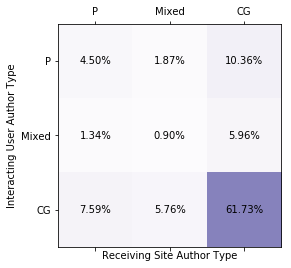

In [25]:
int_author_type_pcts = int_author_type_counts / len(ints) * 100
plt.matshow(int_author_type_pcts, cmap=new_cmap)
plt.xlabel("Receiving Site Author Type")
plt.ylabel("Interacting User Author Type")
plt.xticks(ticks=[0, 1, 2], labels=author_type_labels)
plt.yticks(ticks=[0, 1, 2], labels=author_type_labels)
for i in range(3):  # user
    for j in range(3):  # site
        pct = f"{int_author_type_pcts[i, j]:.2f}%"
        # sites are along the columns, users are along the rows
        plt.text(j, i, pct, verticalalignment='center', horizontalalignment='center')

plt.show()

NameError: name 'fig' is not defined

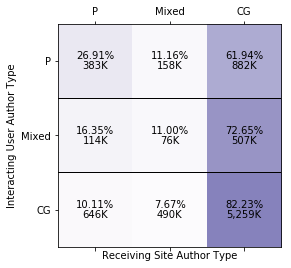

In [26]:
int_author_type_pcts = int_author_type_counts.copy()
for i in range(3):
    user_type_int_total = int_author_type_counts[i,:].sum()
    int_author_type_pcts[i,:] = int_author_type_counts[i,:] / user_type_int_total * 100
plt.matshow(int_author_type_pcts, cmap=new_cmap)
plt.xlabel("Receiving Site Author Type")
plt.ylabel("Interacting User Author Type")
plt.xticks(ticks=[0, 1, 2], labels=author_type_labels)
plt.yticks(ticks=[0, 1, 2], labels=author_type_labels)
for i in range(3):  # user
    for j in range(3):  # site
        pct = f"{int_author_type_pcts[i, j]:.2f}%"
        # sites are along the columns, users are along the rows
        plt.text(j, i, pct, verticalalignment='bottom', horizontalalignment='center')
        count = f"{int(int_author_type_counts[i, j] / 1000):,}K"
        plt.text(j, i, count, verticalalignment='top', horizontalalignment='center')
plt.axhline(0.5, color='black', linewidth=1)
plt.axhline(1.5, color='black', linewidth=1)

fig.savefig(fname=os.path.join(figures_dir,"interactions_by_type.pdf"), dpi=300, bbox_inches='tight', pad_inches = 0)     
plt.show()

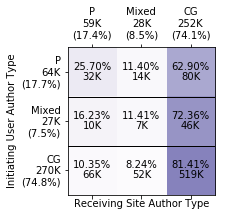

In [36]:
# this shows the percentage of initiations from users to each type of site, broken down by initiating user type 
fig, ax = plt.subplots(1, 1, figsize=(5.47807, 2.8))

init_author_type_pcts = init_author_type_counts.copy()
for i in range(3):
    user_type_init_total = init_author_type_pcts[i,:].sum()
    init_author_type_pcts[i,:] = init_author_type_pcts[i,:] / user_type_init_total * 100
ax.matshow(init_author_type_pcts, cmap=new_cmap)
plt.xlabel("Receiving Site Author Type")
plt.ylabel("Initiating User Author Type")
site_labels = [f"{display_label}\n{int(np.sum(site_df.site_author_type == label)/1000):,}K\n({np.sum(site_df.site_author_type == label) / len(site_df) * 100:.1f}%)"
               for display_label, label
               in zip(author_type_labels, author_type_label_order)
              ]
user_labels = [f"{display_label}\n{int(np.sum(user_df.user_author_type == label)/1000):,}K\n({np.sum(user_df.user_author_type == label) / len(user_df) * 100:.1f}%)"
               for display_label, label
               in zip(author_type_labels, author_type_label_order)
              ]
plt.xticks(ticks=[0, 1, 2], labels=site_labels)
plt.yticks(ticks=[0, 1, 2], labels=user_labels)
for i in range(3):  # user
    for j in range(3):  # site
        pct = f"{init_author_type_pcts[i, j]:.2f}%"
        plt.text(j, i, pct, verticalalignment='bottom', horizontalalignment='center')
        count = f"{int(init_author_type_counts[i, j] / 1000):,}K"
        plt.text(j, i, count, verticalalignment='top', horizontalalignment='center')
plt.axhline(0.5, color='black', linewidth=1)
plt.axhline(1.5, color='black', linewidth=1)

plt.tight_layout(pad=0)
plt.margins(0,0)
fig.savefig(fname=os.path.join(figures_dir,"initiations_author_role_matrix.pdf"), dpi=200, bbox_inches='tight', pad_inches = 0)     
plt.show()

In [93]:
total_patient_sites = np.sum(site_df.site_author_type == 'p')
pct_patient_sites = total_patient_sites / len(site_df)
pct_patient_sites

0.17439353258091617

In [94]:
total_cg_sites = np.sum(site_df.site_author_type == 'cg')
pct_cg_sites = total_cg_sites / len(site_df)
pct_cg_sites

0.7405512111722785

In [95]:
# Patients are X% more likely to connect with patient sites than caregiver sites, 
# relative to the frequency of those sites.
p_site_inits = init_author_type_counts[0,0]
cg_site_inits = init_author_type_counts[0,2]
p_site_inits

32943.0

In [96]:
init_author_type_pcts[0,0] - (pct_patient_sites * 100)

8.262026095297475

In [97]:
init_author_type_pcts[0,2] - (pct_cg_sites * 100)

-11.154110007503732

In [98]:
# Patient authors are 19.4% more likely to connect with patient sites than caregiver sites
(init_author_type_pcts[0,0] - (pct_patient_sites * 100)) - (init_author_type_pcts[0,2] - (pct_cg_sites * 100))

19.416136102801207

In [99]:
# Caregiver authors are 14.4% more likely to connect with caregiver sites than patient sites
(init_author_type_pcts[2,2] - (pct_cg_sites * 100)) - (init_author_type_pcts[2,0] - (pct_patient_sites * 100))

14.437131883286561

In [100]:
(init_author_type_counts[0,0] / total_patient_sites)  / (init_author_type_counts[2,0] / total_cg_sites)

2.118107135685825

## Old approach to user labeling

In [ ]:
def compute_author_type(group):
    if len(group) == 1:
        site = group.iloc[0]
        patient_proportion = site.patient_proportion
        if patient_proportion >= 0.8:
            return 'p'
        elif patient_proportion >= 0.2:
            return 'shared'
        else:
            return 'cg'
    else:  # multiple sites on which this user has authored!
        is_shared = np.any((group.patient_proportion < 0.8)&(group.patient_proportion > 0.2))
        if is_shared:
            return 'shared'
        if np.sum(group.patient_proportion >= 0.8) / len(group) >= 0.5:
            return 'p'
        else:
            return 'cg'

In [ ]:
author_type_series = user_df.groupby('user_id').apply(compute_author_type)

In [ ]:
for key, value in Counter(author_type_series).most_common():
    print(key, value / len(author_type_series))

In [ ]:
author_type_df = author_type_series.rename("author_type").reset_index()
author_type_df.head()

In [ ]:
# save the author type data
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
author_type_dataframe_filepath = os.path.join(author_type_dir, 'author_types.df')
author_type_df.to_feather(author_type_dataframe_filepath)
print("Finished.")

In [ ]:
# read the author type data
author_type_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/author_type"
author_type_dataframe_filepath = os.path.join(author_type_dir, 'author_types.df')
author_type_df = pd.read_feather(author_type_dataframe_filepath)
len(author_type_df)